In [1]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 40.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 78 kB 6.8 MB/s 
     |████████████████████████████████| 69 kB 8.4 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626634 sha256=08fbf3104999ae07aa239db28bb9ab7eb280fed3d54bcde5b581ee06b7575cfc
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2022.1.9-py2.py3-none-any.whl size=64666 sha256=f69d2894ae060521e2a615c64f38b1008eae164fc0ae197ba29b08aa346fcffc
  Stored in directory: /root/.cache/pip/wheels/11/d8/85/01a8cf50977badf2da880865124b159b112b861655a9b631d3
Successfully built pycuda pytools


In [2]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [3]:
ker = SourceModule(
    """
    #define x (threadIdx.x)

    __device__ void tall_matrix_multiply(float *matrix, float *vector, float *out, int width) {
        int index = x * width;

        for (int i = 0; i < width; i++) {
            out[x] += matrix[index + i] * vector[i];
        }
    }

    __device__ void atomic_sub(float *vector1, float *vector2, int width) {
        
        vector1[x] -= vector2[x];
    }

    __device__ void wide_matrix_multiply(float *matrix, float *vector, float *grad, int width, int length) {
        int wideness = length / width;
        int row = x / wideness;
        int col = x % wideness;
        int index1 = row * length;
        int index2 = row * wideness;

        for (int i = 0; i < width; i++) {
            int k = col * width + i;

            grad[index2 + col] += matrix[index1 + k] * vector[k];
        }

        if (x < width) {
            int index3 = wideness * x;

            for (int i = 1; i < wideness; i++) {
                grad[index3] += grad[index3 + i];
            }
        }
    }

    __device__ void update(float *vector, float *grad, float learning_rate, int width, int length) {
        int wideness = length / width;

        if (x < width) {
            int index3 = x * wideness;

            vector[x] -= grad[index3] * learning_rate;
        }
    }

    __global__ void main_function(float *matrix1, float *matrix2, float *vector1, float *vector2, float *out, float *grad, int width, int length, float learning_rate) {

        // optimize
        tall_matrix_multiply(matrix1, vector1, out, width);

        __syncthreads();

        atomic_sub(out, vector2, width);
        
        __syncthreads();
        
        wide_matrix_multiply(matrix2, out, grad, width, length);
        
        __syncthreads();

        update(vector1, grad, learning_rate, width, length);

        __syncthreads();

    }
    """
)

calculate = ker.get_function("main_function")

In [31]:
length = 800
width = 25
wideness = np.int32(length / width)

lr = np.float32(1e-6)

A = np.float32(np.random.randn(length,width))
b = np.float32(np.random.randn(length))
theta = np.float32(np.random.randn(width))
out = np.float32(np.zeros_like(b))
grad = np.float32(np.zeros((width,wideness)))

A1_gpu = gpuarray.to_gpu(A.reshape(length*width))
A2_gpu = gpuarray.to_gpu(A.T.reshape(length*width))
b_gpu = gpuarray.to_gpu(b)
theta_gpu = gpuarray.to_gpu(theta)
out_gpu = gpuarray.to_gpu(out)
grad_gpu = gpuarray.to_gpu(grad.reshape(width*wideness))

t1 = time()
calculate(A1_gpu, A2_gpu, theta_gpu, b_gpu, out_gpu, grad_gpu, np.int32(width), np.int32(length), lr, block=(length,1,1), grid=(1,1,1))
t2 = time()

theta_gpu = theta_gpu.get()
theta_cpu = theta - np.dot(A.T,(np.dot(A,theta) - b)) * lr

print(f"Does it right?: {np.allclose(theta_cpu, theta_gpu)}")
print(f"How about 2-Norm?: {np.linalg.norm(theta_cpu - theta_gpu)}")
print(f"How does it take in GPU?: {round((t2 - t1) * 300, 5)} s")

Does it right?: True
How about 2-Norm?: 0.0
How does it take in GPU?: 0.13969 s


Legend...

# Test... 
dugundugun<br>
daegeundaegeun

In [35]:
length = 1000
width = 150
wideness = np.int32(length / width)

lr = np.float32(3e-5)

A = np.float32(np.random.randn(length,width))
b = np.float32(np.random.randn(length))
theta = np.float32(np.random.randn(width))
out = np.float32(np.zeros_like(b))
grad = np.float32(np.zeros((width,wideness)))

A1_gpu = gpuarray.to_gpu(A.reshape(length*width))
A2_gpu = gpuarray.to_gpu(A.T.reshape(length*width))
b_gpu = gpuarray.to_gpu(b)
theta_gpu = gpuarray.to_gpu(theta)
out_gpu = gpuarray.to_gpu(out)
grad_gpu = gpuarray.to_gpu(grad.reshape(width*wideness))

init_vec1 = gpuarray.empty_like(out_gpu)
init_vec2 = gpuarray.empty_like(grad_gpu)

t1 = time()
for i in range(200):
    calculate(A1_gpu, A2_gpu, theta_gpu, b_gpu, out_gpu, grad_gpu, np.int32(width), np.int32(length), lr, block=(length,1,1), grid=(1,1,1))
    out_gpu[:] = init_vec1[:]
    grad_gpu[:] = init_vec2[:]
t2 = time()

theta_gpu = theta_gpu.get()

t3 = time()
theta_cpu = np.linalg.lstsq(A, b, rcond=None)[0]
t4 = time()

error_gpu = np.dot(A, theta_gpu) - b
error_cpu = np.dot(A, theta_cpu) - b

print(f"Error in GPU: {np.linalg.norm(error_gpu)}")
print(f"Error in CPU: {np.linalg.norm(error_cpu)}")
print(f"Upgrade: {round((t2 - t1) / (t4 - t3), 4)}")

Error in GPU: 31.04603385925293
Error in CPU: 28.42842674255371
Upgrade: 0.8564


# Test with data set

In [145]:
class lstsq_dg:

    def __init__(self, A, b, learning_rate=3e-5, initial_value="gaussian"):
        self.A = np.float32(A)
        self.b = np.float32(b)
        self.lr = np.float32(learning_rate)
        
        # get data size
        self.length = self.A.shape[0]
        self.width = self.A.shape[1]
        self.wideness = np.int32(self.length / self.width)

        # create theta with...
        if initial_value == "gaussain":
            self.theta = np.float32(np.random.randn(self.width))
        else:
            self.theta = np.float32(np.random.rand(self.width))

        self.out = np.float32(np.zeros_like(self.b))
        self.grad = np.float32(np.zeros((self.width, self.wideness)))

        # to gpu
        self.A1_gpu = gpuarray.to_gpu(self.A.reshape(self.length*self.width))
        self.A2_gpu = gpuarray.to_gpu(self.A.T.reshape(self.length*self.width))
        self.b_gpu = gpuarray.to_gpu(self.b)
        self.theta_gpu = gpuarray.to_gpu(self.theta)
        self.out_gpu = gpuarray.to_gpu(self.out)
        self.grad_gpu = gpuarray.to_gpu(self.grad.reshape(self.width*self.wideness))

        # for initialize
        self.init_vec1 = gpuarray.empty_like(self.out_gpu)
        self.init_vec2 = gpuarray.empty_like(self.grad_gpu)

    def lstsq(self):
        for epoch in range(10):
            for iter in range(20):
                # calculate
                calculate(self.A1_gpu, self.A2_gpu, self.theta_gpu, self.b_gpu,\
                          self.out_gpu, self.grad_gpu, np.int32(self.width), np.int32(self.length), self.lr,\
                          block=(self.length,1,1), grid=(1,1,1))
        
                # initialize
                self.out_gpu[:] = self.init_vec1[:]
                self.grad_gpu[:] = self.init_vec2[:]

        return self.theta_gpu.get()

In [6]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/lstsq')

Mounted at /content/drive


In [63]:
def port_opt(R, rho):
    T, n = R.shape
    mu = np.sum(R, axis=0).T / T
    KKT = np.vstack([np.column_stack([2 * np.dot(R.T, R), np.ones(n), mu]),\
                     np.hstack([np.ones(n).T, 0, 0]),
                     np.hstack([mu.T, 0, 0])])

    t1 = time()
    wz1z2 = np.linalg.lstsq(KKT, np.hstack([2*rho*T*mu, 1, rho]), rcond=None)[0]
    t2 = time()

    w = wz1z2[:n]

    return w, round(t2 - t1, 4)

In [68]:
def port_opt_dg(R, rho, learning_rate):
    T, n = R.shape
    mu = np.sum(R, axis=0).T / T
    KKT = np.vstack([np.column_stack([2 * np.dot(R.T, R), np.ones(n), mu]),\
                     np.hstack([np.ones(n).T, 0, 0]),
                     np.hstack([mu.T, 0, 0])])
    t1 = time()
    wz1z2 = lstsq_dg(KKT, np.hstack([2*rho*T*mu, 1, rho]), learning_rate).lstsq()
    t2 = time()

    w = wz1z2[:n]

    return w, round(t2 - t1, 4)

In [80]:
R = np.loadtxt("R.txt")[:1000]
T, n = R.shape
rho = 0.1 / T

w_cpu, duration_cpu = port_opt(R, rho)
r_cpu = np.dot(R, w_cpu)

pf_return_cpu = T * sum(r_cpu) / len(r_cpu)
pf_risk_cpu = np.sqrt(T) * np.std(r_cpu)

print(f"return in CPU: {pf_return_cpu}")
print(f"risk in CPU: {pf_risk_cpu}")
print("\n")

w_gpu, duration_gpu = port_opt_dg(R, rho, 3e-5)
r_gpu = np.dot(R, w_gpu)

pf_return_gpu = T * sum(r_gpu) / len(r_gpu)
pf_risk_gpu = np.sqrt(T) * np.std(r_gpu)

print(f"return in GPU: {pf_return_gpu}")
print(f"risk in GPU: {pf_risk_gpu}")
print("\n")

print(f"Duration in CPU: {duration_cpu} s")
print(f"Duration in GPU: {duration_gpu} s")
print(f"Upgrade: {round((duration_gpu) / (duration_cpu), 4)}")

return in CPU: 0.10000000000000085
risk in CPU: 0.015989047555521683


return in GPU: -1.298221317053275
risk in GPU: 2.046701811118525


Duration in CPU: 0.0003 s
Duration in GPU: 0.0236 s
Upgrade: 78.6667


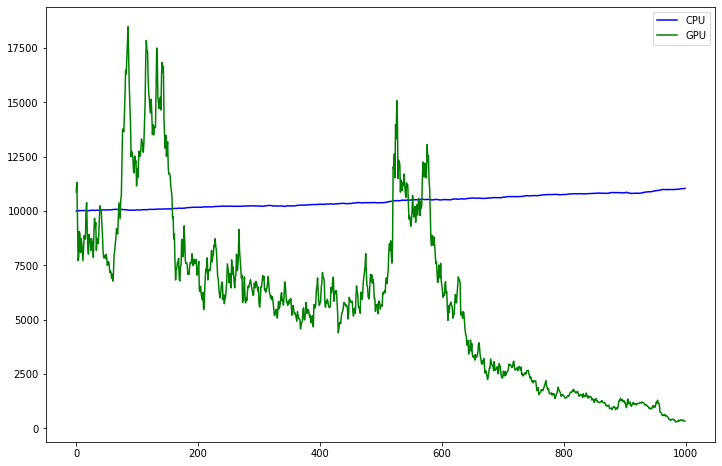

In [81]:
cum_value = lambda r: 10000 * np.cumprod(1+r)

plt.figure(figsize=(12,8))

plt.plot(np.arange(T), cum_value(r_cpu), 'blue')
plt.plot(np.arange(T), cum_value(r_gpu), 'green')
plt.legend(['CPU', 'GPU'])
plt.show()

# ..?

In [76]:
length = 1000
width = 20
wideness = np.int32(length / width)

A = np.float32(np.random.randn(length,width))
b = np.float32(np.random.randn(length))

dg = lstsq_dg(A, b)
t1 = time()
theta_gpu = dg.lstsq()
t2 = time()

t3 = time()
theta_cpu = np.linalg.lstsq(A, b, rcond=None)[0]
t4 = time()

error_gpu = np.dot(A, theta_gpu) - b
error_cpu = np.dot(A, theta_cpu) - b

print(f"Error in GPU: {np.linalg.norm(error_gpu)}")
print(f"Error in CPU: {np.linalg.norm(error_cpu)}")
print(f"Diffrence: {np.linalg.norm(theta_gpu - theta_cpu)}")
print(f"Upgrade: {round((t2 - t1) / (t4 - t3), 4)}")

Error in GPU: 32.231346130371094
Error in CPU: 32.15663528442383
Diffrence: 0.07511139661073685
Upgrade: 5.3802


In [160]:
length = 1000
width = 20
wideness = np.int32(length / width)

A = np.float32(np.random.rand(length,width))
b = np.float32(np.random.rand(length))

dg = lstsq_dg(A, b, learning_rate=5e-5, initial_value="gaussian")
t1 = time()
theta_gpu = dg.lstsq()
t2 = time()

t3 = time()
theta_cpu = np.linalg.lstsq(A, b, rcond=None)[0]
t4 = time()

error_gpu = np.dot(A, theta_gpu) - b
error_cpu = np.dot(A, theta_cpu) - b

print(f"Error in GPU: {np.linalg.norm(error_gpu)}")
print(f"Error in CPU: {np.linalg.norm(error_cpu)}")
print(f"Diffrence: {np.linalg.norm(theta_gpu - theta_cpu)}")
print(f"Upgrade: {round((t2 - t1) / (t4 - t3), 4)}")

Error in GPU: 10.684513092041016
Error in CPU: 9.203388214111328
Diffrence: 0.5968097448348999
Upgrade: 6.9893


How does it take: 0.03283214569091797 s


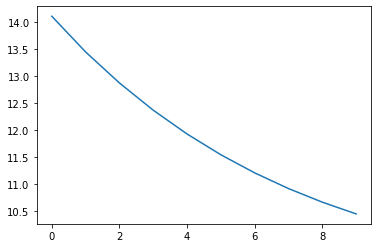

In [158]:
length = 1000
width = 20
wideness = np.int32(length / width)

epoches = 10
iterations = 20

A = np.float32(np.random.rand(length,width))
b = np.float32(np.random.rand(length))

error_list = np.zeros((epoches))

dg = lstsq_dg(A, b, learning_rate=5e-5, initial_value="gaussian")

t1 = time()
for epoch in range(epoches):
    for iter in range(iterations):
        calculate(dg.A1_gpu, dg.A2_gpu, dg.theta_gpu, dg.b_gpu, dg.out_gpu, dg.grad_gpu, np.int32(width), np.int32(length), dg.lr, block=(length,1,1), grid=(1,1,1))
        
        dg.out_gpu[:] = dg.init_vec1[:]
        dg.grad_gpu[:] = dg.init_vec2[:]
    
    error = np.linalg.norm(np.dot(A, dg.theta_gpu.get()) - b)
    error_list[epoch] = error
t2 = time()

print(f"How does it take: {t2 - t1} s")
plt.plot(error_list)
plt.show()